In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
#create set
np.random.seed(9)
n = 3
k = 20
arr = np.random.randint(1, k, n, dtype=int,requires_grad=False)
w = np.random.randint(0, sum(arr))
w = 11
print(f"{arr}, target = {w}")

[ 2  9 18], target = 11


In [3]:
coeffs = []
ops = []

for i in range(n):
    coeffs.append(-w*arr[i])
    ops.append(qml.Identity(i)-qml.PauliZ(i))
    for j in range(n):
        coeffs.append(arr[i]*arr[j]/4)
        ops.append((qml.Identity(i)-qml.PauliZ(i))@(qml.Identity(j)-qml.PauliZ(j)))
coeffs.append(w**2)
ops.append(qml.Identity())
        
H_c = qml.Hamiltonian(coeffs, ops).simplify()

In [4]:
from pennylane import qaoa

coeffs = np.ones(n)
obs = [qml.PauliX(i) for i in range(n)]
H_m = qml.Hamiltonian(coeffs, obs)

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, H_c)
    qaoa.mixer_layer(alpha, H_m)

wires = range(n)
depth = 12

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [5]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost(params):
    circuit(params)
    return qml.expval(H_c)

Step: 0 	 Cost: 180.92424080240096


/home/luke/Documents/QML/ve/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Step: 10 	 Cost: 72.17456601311297
Step: 20 	 Cost: 31.081465019824094
Step: 30 	 Cost: 17.50965636427341
Step: 40 	 Cost: 2.8227879724463207
Step: 50 	 Cost: 2.599502715538563
Step: 60 	 Cost: 0.8466316409937917
Step: 70 	 Cost: 0.40841710509475604
Step: 80 	 Cost: 0.20580356956145351
Step: 90 	 Cost: 0.11108212384039007
Step: 100 	 Cost: 0.061863774686841566
Step: 110 	 Cost: 0.03055866211802538
Step: 120 	 Cost: 0.015654216464341175
Step: 130 	 Cost: 0.42648971394730495
Step: 140 	 Cost: 4.737964289511311
Step: 150 	 Cost: 1.961073227063082
Step: 160 	 Cost: 0.6116532786866458
Step: 170 	 Cost: 0.5320957273714981
Step: 180 	 Cost: 0.69271875774146
Step: 190 	 Cost: 8.598887048093715
Optimal Parameters:
[[0.41109924 0.1800137  0.86553521 0.94346439 0.08244323 0.65156397
  0.5513685  0.83245418 0.64567296 0.57259098 0.65813727 0.43519721]
 [0.55546169 0.82175832 0.52098785 1.02261732 0.83281871 0.95251727
  0.22380991 0.5545443  0.89003279 0.69125082 0.92312138 0.91203303]]


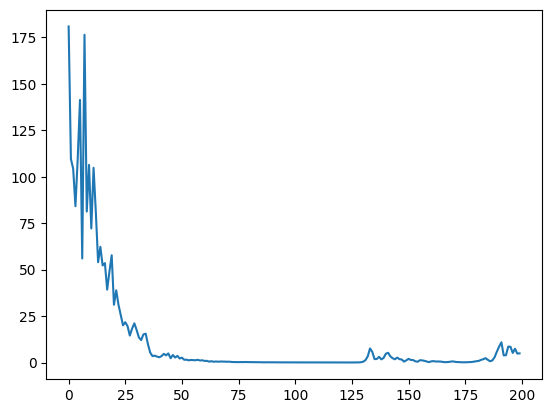

In [6]:
l = 0.01
optimizer = qml.AdamOptimizer(l)
steps = 200
param_shape = (2, depth)
params = np.random.rand(*param_shape)

costs = []

for step in range(steps):
    params, c = optimizer.step_and_cost(cost, params)
    costs.append(c)
    if step % 10 == 0:
        print(f"Step: {step} \t Cost: {c}")

print("Optimal Parameters:")
print(params)

plt.plot(range(steps), costs)
plt.show()

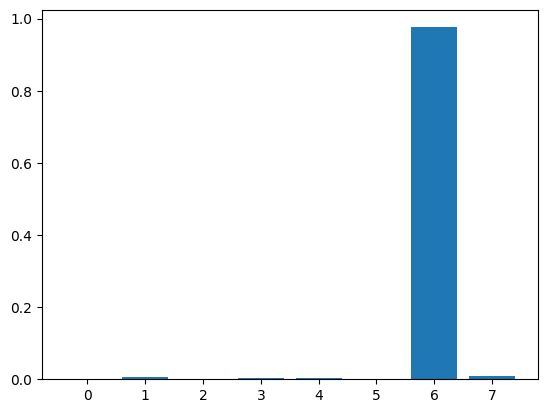

In [7]:
@qml.qnode(dev)
def prob_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = prob_circuit(params[0], params[1])

plt.bar(range(2**len(wires)), probs)
plt.show()

In [8]:
sorted_data_with_indices = sorted(enumerate(probs), key=lambda x: x[1])
permutation = np.array([x[0] for x in sorted_data_with_indices])
print(bin(permutation[-1]))
print(bin(permutation[-2]))
print(bin(permutation[-3]))

0b110
0b111
0b1
